

# Removing muscle ICA components

Gross movements produce widespread high-frequency activity across all channels
that is usually not recoverable and so the epoch must be rejected as shown in
`ex-muscle-artifacts`. More ubiquitously than gross movements, muscle
artifact is produced during postural maintenance. This is more appropriately
removed by ICA otherwise there wouldn't be any epochs left! Note that muscle
artifacts of this kind are much more pronounced in EEG than they are in MEG.


In [11]:
# Authors: Alex Rockhill <aprockhill@mailbox.org>
#
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [23]:
import pandas as pd
import mne

print("Cargando archivo .txt en pandas...")
# --- 1. Cargar tu archivo .txt en un DataFrame ---
df = pd.read_csv(
    'UltraISB.txt',
    comment='%',            # Ignora las líneas de metadatos que empiezan con '%'
    sep=',',                # El separador es una coma
    skipinitialspace=True   # Ignora espacios después de la coma
)

print("Datos cargados en pandas. Ahora convirtiendo a formato MNE...")

# --- 2. Preparar los datos para MNE ---

# Tasa de muestreo (lo leímos del encabezado de tu .txt)
sfreq = 250  # 250 Hz

# Lista de las columnas que son datos de EEG
# (Basado en el encabezado de tu .txt)
ch_names = ['EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2', 'EXG Channel 3',
            'EXG Channel 4', 'EXG Channel 5', 'EXG Channel 6', 'EXG Channel 7']

# Especifica que todos estos canales son de tipo 'eeg'
ch_types = ['eeg'] * len(ch_names)

# Extrae solo los datos de EEG del DataFrame
data = df[ch_names]

# --- 3. Convertir de Pandas a un objeto MNE Raw ---

# MNE espera los datos en Volts (V), pero OpenBCI los da en valores muy
# grandes (probablemente microvolts, µV). Los convertimos a Volts.
data_in_volts = data.values * 1e-6  # Multiplica por 10^-6

# MNE espera los datos en formato (canales, muestras).
# Pandas los da en (muestras, canales), así que necesitamos transponerlos (.T)
data_for_mne = data_in_volts.T

# Crea el objeto 'info' que MNE necesita (nombres de canales, tasa, tipo)
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# ¡Crea el objeto 'raw' que usará el resto de tu notebook!
raw = mne.io.RawArray(data_for_mne, info)

print("\n¡Conversión a MNE exitosa!")
print(raw)

# --- 4. APLICAR FILTRO NOTCH (NUEVO PASO) ---
# Esto elimina el ruido de la línea eléctrica.
# 🚨 Ajusta freqs=60 (América) o freqs=50 (Europa/otras regiones) según tu ubicación.
print("\nAplicando filtro Notch (60 Hz)...")
raw.notch_filter(freqs=60, fir_design='firwin')

# Si estuvieras en una región de 50 Hz, usarías esta línea en su lugar:
# raw.notch_filter(freqs=50, fir_design='firwin')

print("Filtro Notch aplicado.")

# (Opcional) Imprime la información de 'raw' para verificar
print(raw.info)

Cargando archivo .txt en pandas...
Datos cargados en pandas. Ahora convirtiendo a formato MNE...
Creating RawArray with float64 data, n_channels=8, n_times=180227
    Range : 0 ... 180226 =      0.000 ...   720.904 secs
Ready.

¡Conversión a MNE exitosa!
<RawArray | 8 x 180227 (720.9 s), ~11.0 MiB, data loaded>

Aplicando filtro Notch (60 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtro Notch aplicado.
<Info | 7 non-empty values
 bads: []
 ch_names: EXG Channel 0, EX

In [24]:
import mne

data_path = mne.datasets.sample.data_path()
raw_fname = data_path / "MEG" / "sample" / "sample_audvis_raw.fif"
raw = mne.io.read_raw_fif(raw_fname)
raw.crop(tmin=100, tmax=130)  # take 30 seconds for speed

# pick only EEG channels, muscle artifact is basically not picked up by MEG
# if you have a simultaneous recording, you may want to do ICA on MEG and EEG
# separately
raw.pick(picks="eeg", exclude="bads")

# ICA works best with a highpass filter applied
raw.load_data()
raw.filter(l_freq=1.0, h_freq=None)

Opening raw data file C:\Users\ADMIN\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 18019  =      0.000 ...    30.001 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1983 samples (3.302 s)



<Raw | sample_audvis_raw.fif, 59 x 18020 (30.0 s), ~11.1 MiB, data loaded>

Run ICA



In [25]:
# If you want to use picard you can install it in the notebook:
# %pip install picard
# Fall back to 'fastica' automatically if picard isn't available.

try:
    ica = mne.preprocessing.ICA(
        n_components=8, method="picard", max_iter="auto", random_state=97
    )
    ica.fit(raw)
except ImportError:
    print("picard not available; falling back to 'fastica'. To install picard run: %pip install picard")
    ica = mne.preprocessing.ICA(
        n_components=8, method="fastica", max_iter="auto", random_state=97
    )
    ica.fit(raw)

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 8 components
picard not available; falling back to 'fastica'. To install picard run: %pip install picard
Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.4s.


Remove components with postural muscle artifact using ICA



Creating RawArray with float64 data, n_channels=8, n_times=18020
    Range : 85861 ... 103880 =    142.955 ...   172.956 secs
Ready.


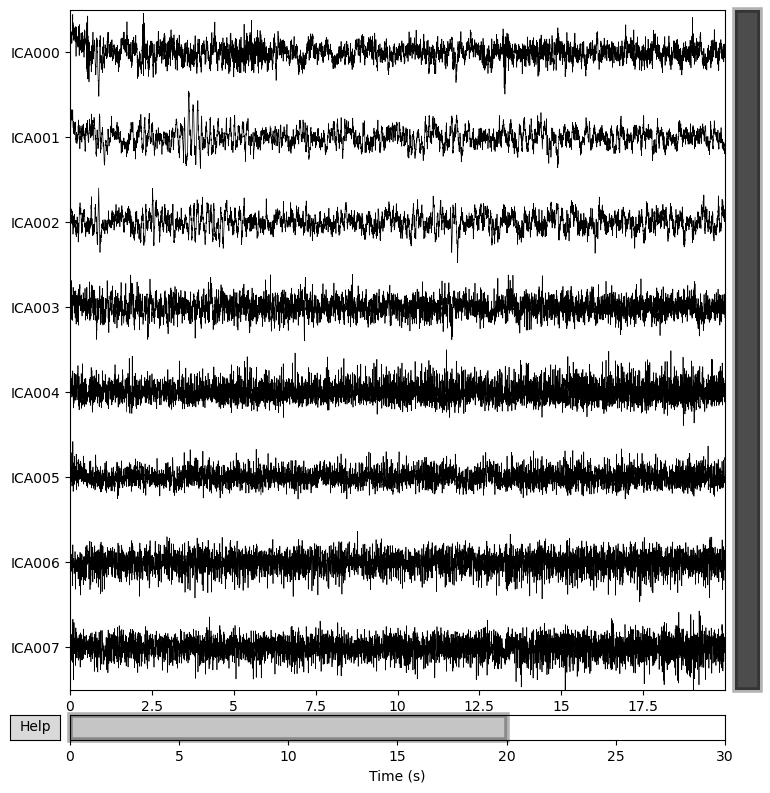

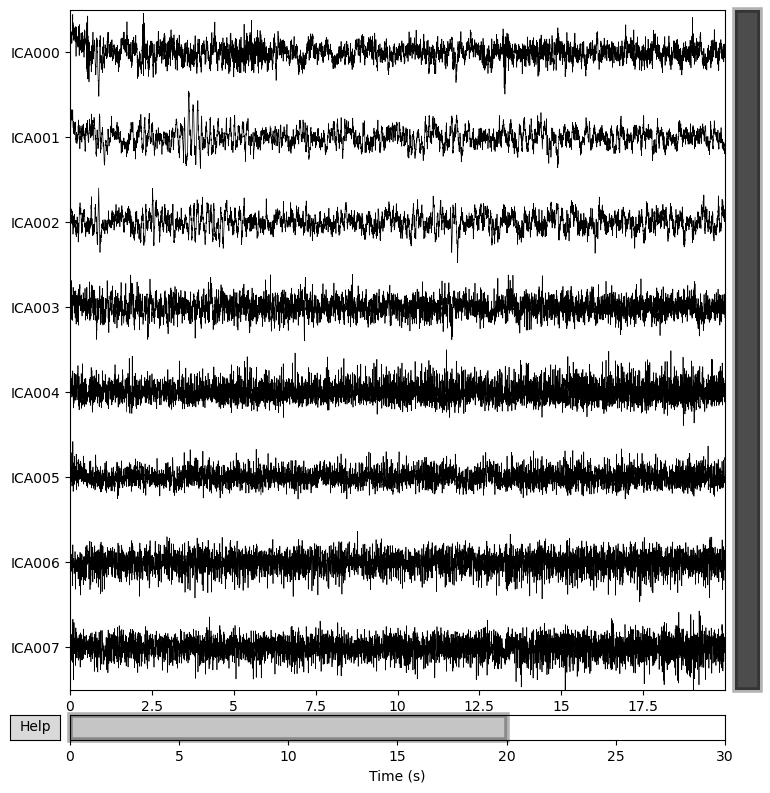

In [21]:
ica.plot_sources(raw)

By inspection, let's select out the muscle-artifact components based on
:footcite:`DharmapraniEtAl2016` manually.

The criteria are:

- Positive slope of log-log power spectrum between 7 and 75 Hz
  (here just flat because it's not in log-log)
- Peripheral focus or dipole/multi-pole foci (the blue and red
  blobs in the topomap are far from the vertex where the most
  muscle is)
- Single focal point (low spatial smoothness; there is just one focus
  of the topomap compared to components like the first ones that are
  more likely neural which spread across the topomap)

The other attribute worth noting is that the time course in
:func:`mne.preprocessing.ICA.plot_sources` looks like EMG; you can
see spikes when each motor unit fires so that the time course looks fuzzy
and sometimes has large spikes that are often at regular intervals.

ICA component 13 is a textbook example of what muscle artifact looks like.
The focus of the topomap for this component is right on the temporalis
muscle near the ears. There is also a minimum in the power spectrum at around
10 Hz, then a maximum at around 25 Hz, generally resulting in a positive
slope in log-log units; this is a very typical pattern for muscle artifact.



    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated


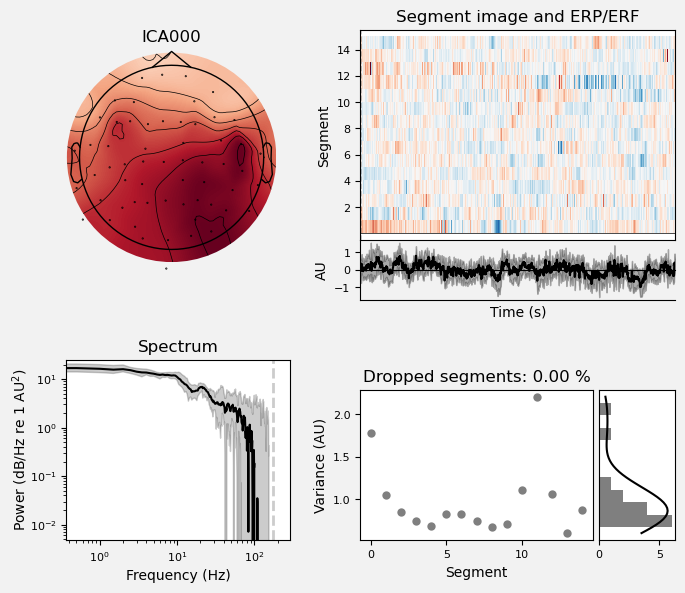

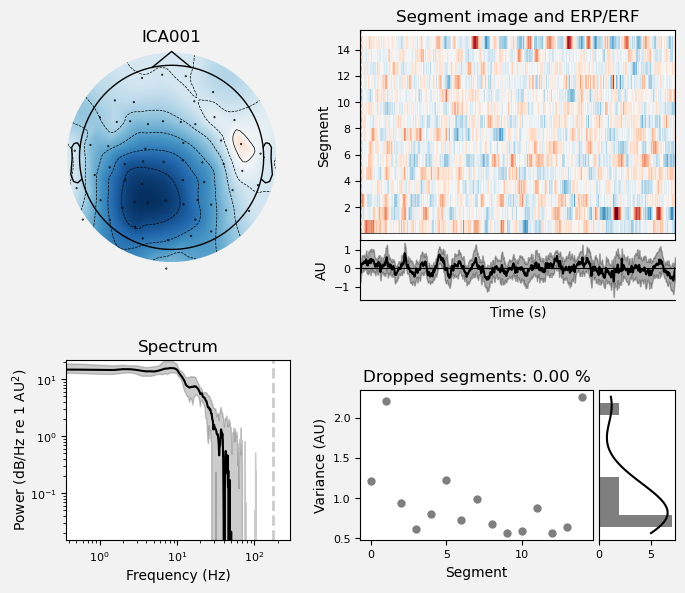

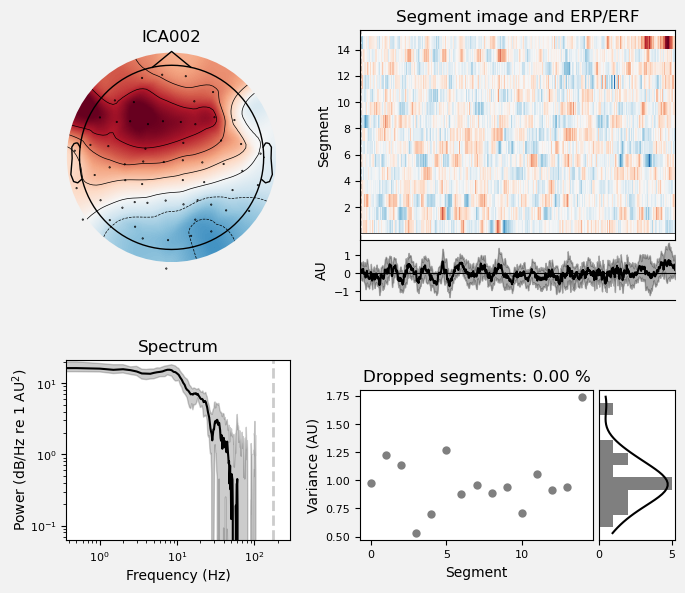

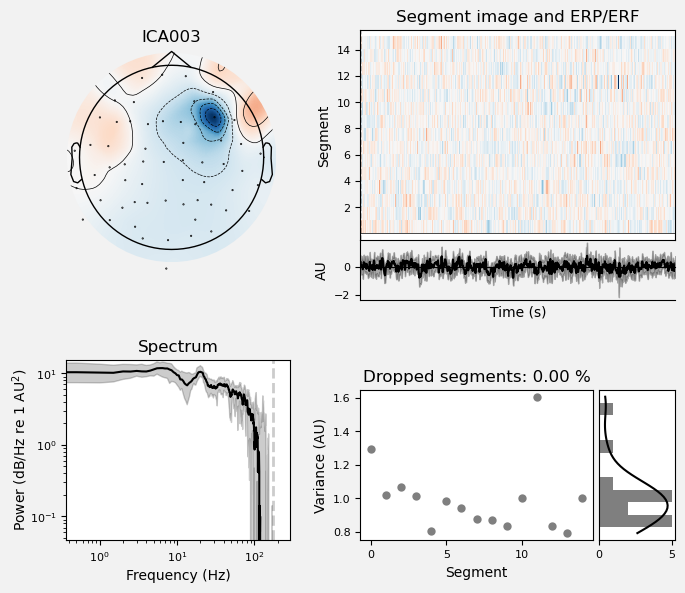

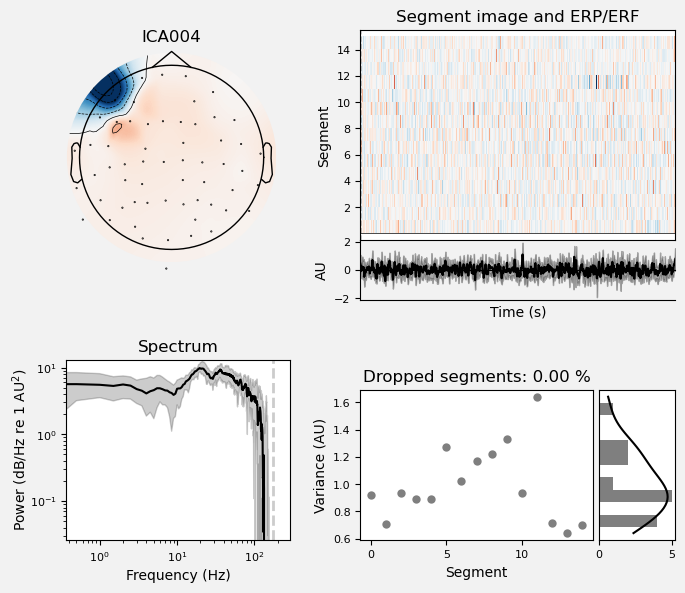

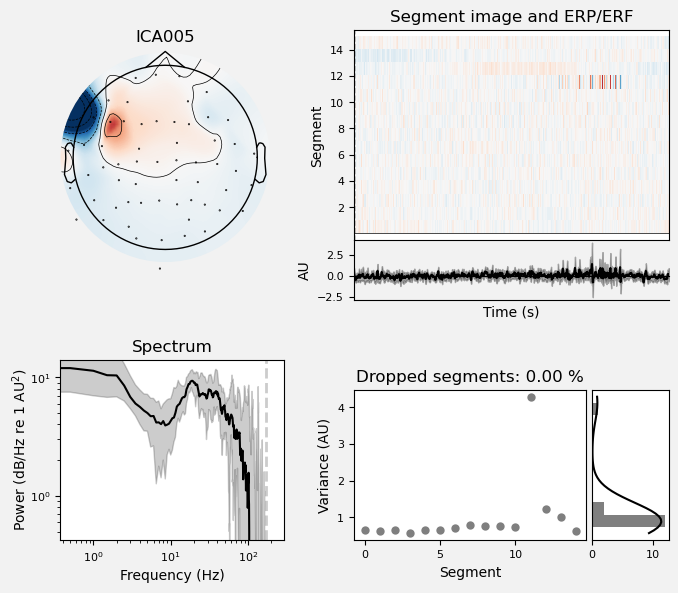

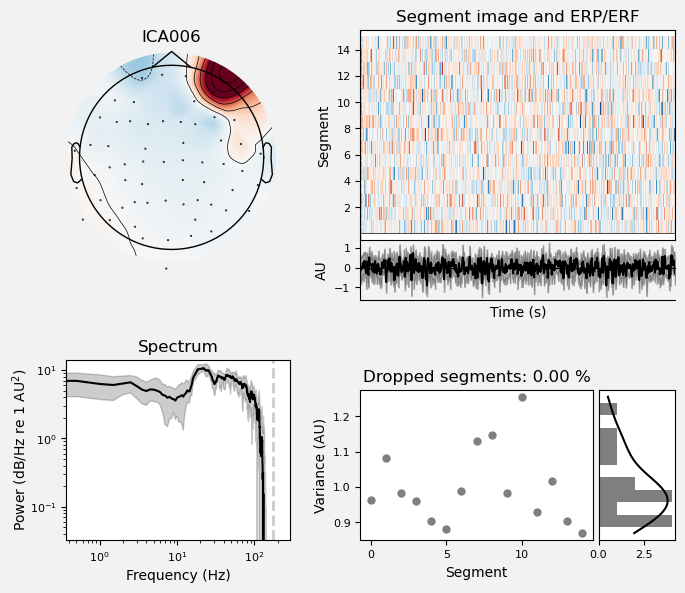

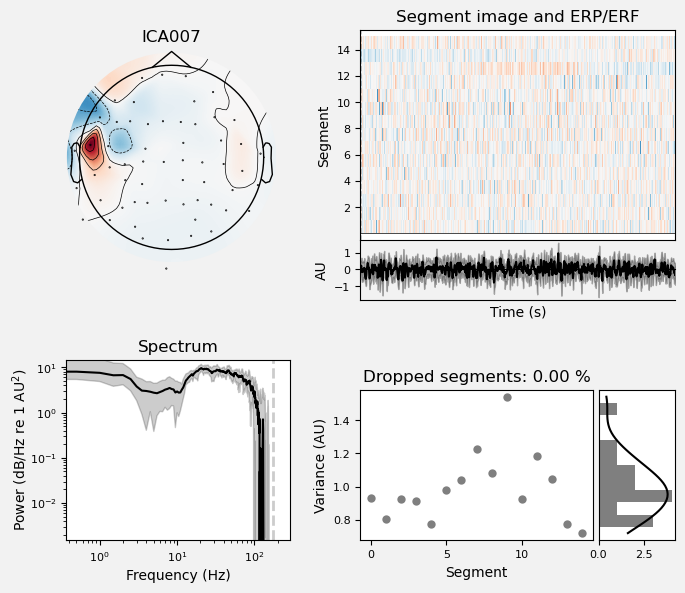

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [22]:
idx = [0, 1, 2, 3, 4, 5, 6, 7]
ica.plot_properties(raw, picks=idx, log_scale=True)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated


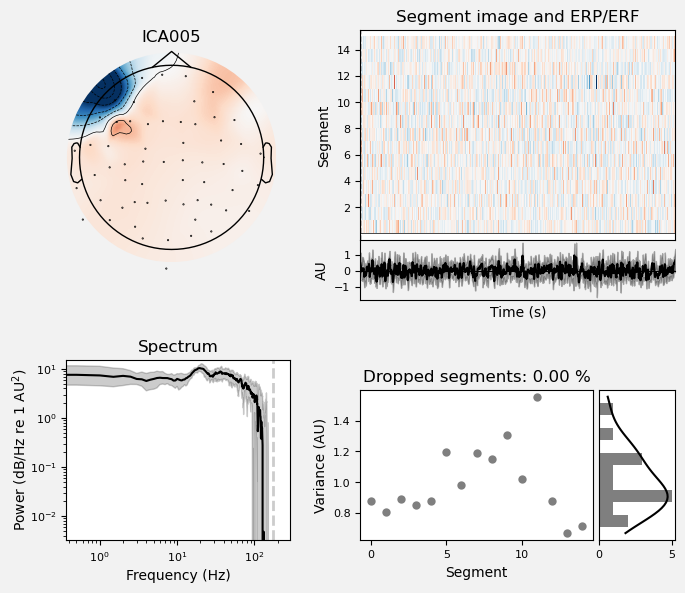

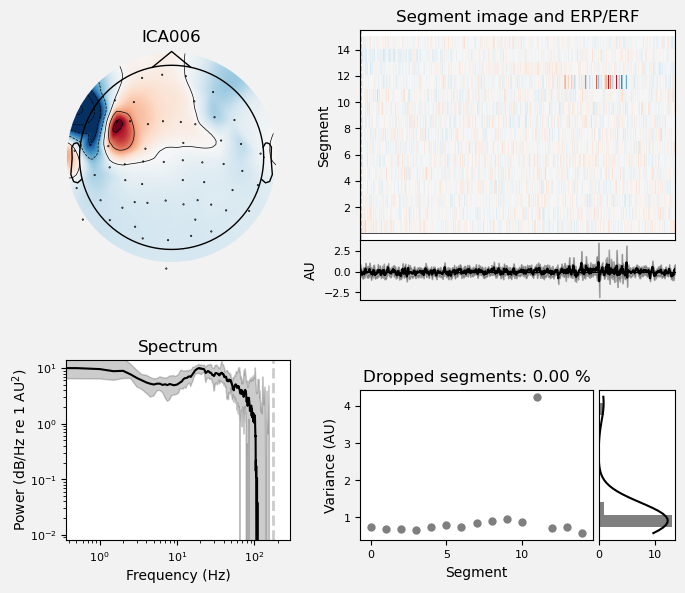

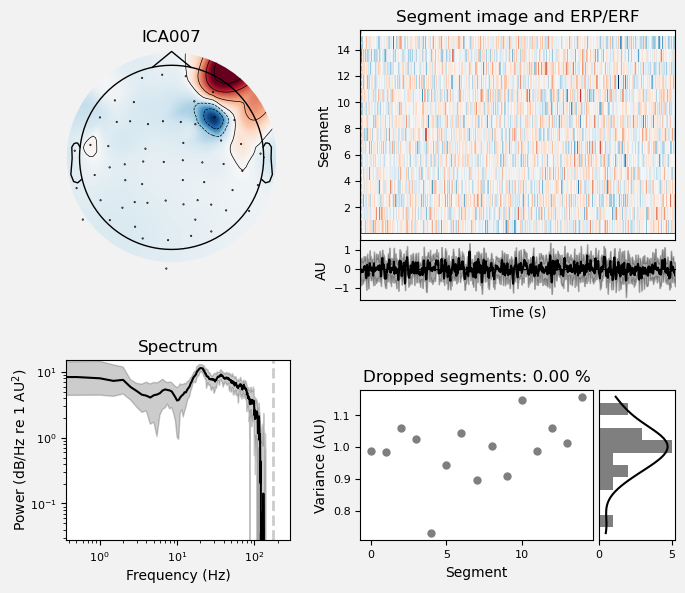

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 59 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 3 ICA components
    Projecting back using 59 PCA components


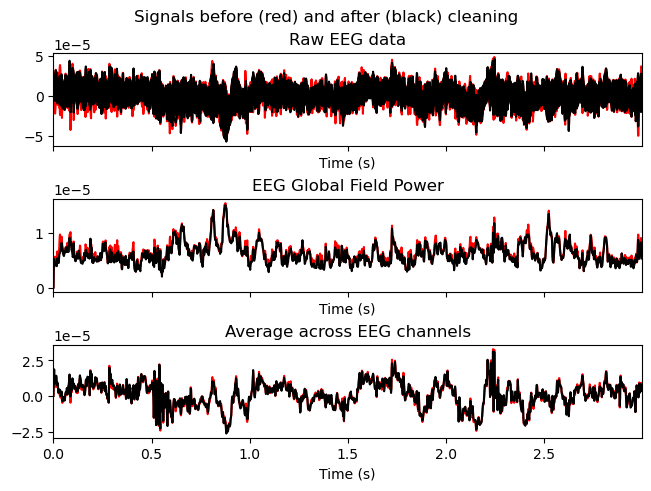

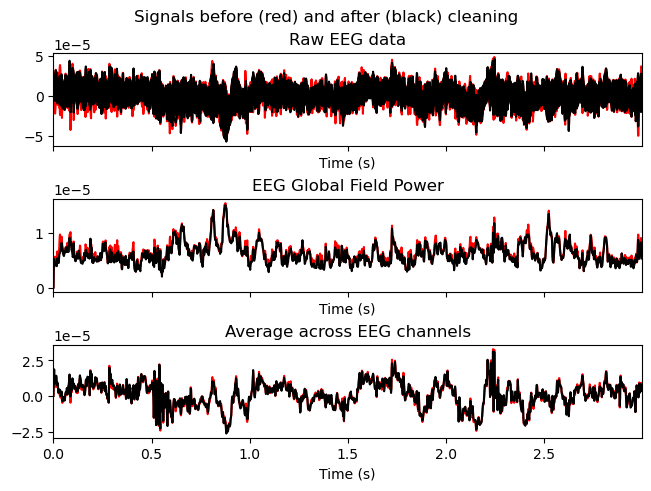

In [27]:
muscle_idx = [5,6,7]
ica.plot_properties(raw, picks=muscle_idx, log_scale=True)

# first, remove blinks and heartbeat to compare
blink_idx = [0]
heartbeat_idx = [5]
ica.apply(raw, exclude=blink_idx + heartbeat_idx)
ica.plot_overlay(raw, exclude=muscle_idx)

Finally, let's try an automated algorithm to find muscle components
and ensure that it gets the same components we did manually.



Effective window size : 3.410 (s)


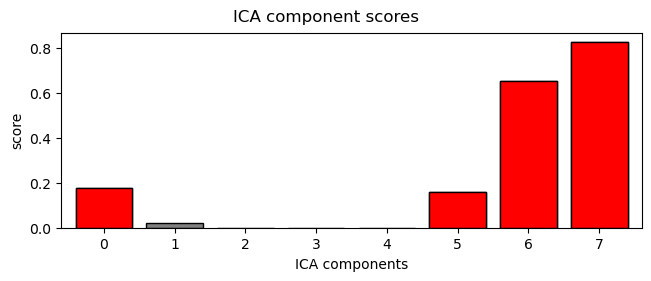

Manually found muscle artifact ICA components:      [5, 6, 7]
Automatically found muscle artifact ICA components: [0, 5, 6, 7]


In [28]:
muscle_idx_auto, scores = ica.find_bads_muscle(raw)
ica.plot_scores(scores, exclude=muscle_idx_auto)
print(
    f"Manually found muscle artifact ICA components:      {muscle_idx}\n"
    f"Automatically found muscle artifact ICA components: {muscle_idx_auto}"
)

## Let's now replicate this on the EEGBCI dataset



In [19]:
for sub in (1, 2):
    raw = mne.io.read_raw_edf(
        mne.datasets.eegbci.load_data(subject=sub, runs=(1,))[0], preload=True
    )
    mne.datasets.eegbci.standardize(raw)  # set channel names
    montage = mne.channels.make_standard_montage("standard_1005")
    raw.set_montage(montage)
    raw.filter(l_freq=1.0, h_freq=None)

    # Run ICA
    ica = mne.preprocessing.ICA(
        n_components=15, method="picard", max_iter="auto", random_state=97
    )
    ica.fit(raw)
    ica.plot_sources(raw)
    muscle_idx_auto, scores = ica.find_bads_muscle(raw)
    ica.plot_properties(raw, picks=muscle_idx_auto, log_scale=True)
    ica.plot_scores(scores, exclude=muscle_idx_auto)

    print(
        f"Manually found muscle artifact ICA components:      {muscle_idx}\n"
        "Automatically found muscle artifact ICA components: "
        f"{muscle_idx_auto}"
    )

TypeError: load_data() got an unexpected keyword argument 'subject'. Did you mean 'subjects'?

## References

Dhani Dharmaprani, Hoang K. Nguyen, Trent W. Lewis, Dylan DeLosAngeles, John O. Willoughby, and Kenneth J. Pope. A comparison of independent component analysis algorithms and measures to discriminate between EEG and artifact components. In 2016 38th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), 825–828. Orlando, FL, USA, 2016. IEEE. doi:10.1109/EMBC.2016.7590828.

